In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

How impactful is the addition of supplemental locations to the results of QMD? 
Let’s compare biases between GEFS (in lieu of full blend stack) and URMA with and withoutsupplemental locations.s

First, how are supplemental locations actually used? 
       
        "Presumably, the population of CDFs using the forecast and analyzed data at additional supplemental locations will help ameliorate sampling  error while still preserving the ability to correctly estimate location-dependent biases," (Hamill+2017). 


IOW, the supplemental locations are chosen to provide attional data points to increase the sample size of the precipitation CDFs, increasing forecast reliability and skill without the need for actually *new, independent* data measurements.

So what we should see is a decrease in bias between forecast and analysis when using supplemental locations.


## utils

In [25]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [26]:
#get CONUS lat/lons
ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_4.co.2p5.nc',
             mode="r")

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data
ds.close()

In [27]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

# Gather data

We'll select 3 seasons worth of data: **January** and **July** to get a feel for any variability in the effectiveness of SLs with season (something we've already identified as a possible obstacle in previous analysis).

In QMD processing, 60 days worth of data are used to construct the precipitation CDFs. So we'll choose a day in the 3 months from above, and load in the previous 60 days. I'll stick with **2023 t0z** data at a lead time of **96h** for this analysis. (One bookkeeping thing with this is when using xarray to load in multiple files, I am not sure how to deal with different days **+** different months. So I think I will just do each month's analysis serially?)

### January 15 2023

From trial and error, I've deduced that using xarray to load hundreds - thousands of files and asking it to interp to CONUS is just too big (and really, we figured this out with MSWEP). So instead, I will be breaking that computation down into steps. First, for each day, load in all GEFS members and interp to CONUS, then get the precip data at the selected station locations. Then we'll just have a relatively small array to do analysis from. I'll repeat with URMA even though that should be a bit more tractable since we just have one array per day instead of 30. 

I also spent a fair bit of time ruminating on how to concat the GEFS files, since there's ensemble member **and** refDate...but since all of this data will be combined to make a CDF for January 15 (the chosen analysis date), it shouldn't actually matter to keep track of what ensemble/refDate each file corresponds to? But I'll check on this assumption later...

In [28]:
#first, get CONUS grid info
from nimbl.metadata import get_metadata
import grib2io

conus_grid_def = get_metadata('grib2_section3', model='blend',region='co' )
conus_grid = grib2io.Grib2GridDef(conus_grid_def[4], conus_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


Ok need to think about this for a sec (refDate, leadTime, etc.). If we're using January 15 0z, leadtime 96h, I believe we use URMA data from that same initialization date (January 15 0z) for QMD and then we analyze bias for the actual refDate (January 19 0z). So load in URMA on same days as GEFS above for QMD, then load in the validDate URMA later for bias analysis.

In [6]:
## GEFS
precip_at_stations = np.zeros((60, 30, len(st_names))) #days, ensemble mems, stations

start_day = datetime.date(2023,1,15)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        precip_at_stations[day, mem-1, :] = precip[conus_gp[0], conus_gp[1]]

  0%|          | 0/60 [00:00<?, ?it/s]

In [7]:
## URMA ##
urma_files = sorted(glob('/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/*/urma2p5.*.pcp_06h.wexp.grb2'))

urma_at_stations = np.zeros((60,len(st_names))) #days, stations

bad_count = 0
start_day = datetime.date(2023,1,15)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    try:
        ds = xr.open_dataset(file, engine='grib2io')
    except:
        bad_count += 1
        urma_at_stations[day, :] = np.full(len(st_names),np.nan)
        continue
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    urma_at_stations[day, :] = precip[conus_gp[0], conus_gp[1]]

  0%|          | 0/60 [00:00<?, ?it/s]

In [14]:
this_day

datetime.date(2022, 11, 17)

In [8]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(precip_at_stations<0.254, precip_at_stations*0, precip_at_stations)
clip_urma = np.where(urma_at_stations<0.254, urma_at_stations*0, urma_at_stations)

# Quantile Mapping ala Adam

In a long discussion on 7/11, Adam showed his version of doing quantile mapping without the need to curve fit, which feels more correct to me. This also means the bookkeeping of xsum, npositive, alphas, and fraction zeros is unncessary. Since I'm not doing the full blend stack and just want to compare bias with and without supplemental locations, it shouldn't _really_ matter how this forecast dressing is done. So I'm going to trial his method here.

Plotting nonzero GEFS precip values


Text(0.045, 0.25, 'P(precipitation)')

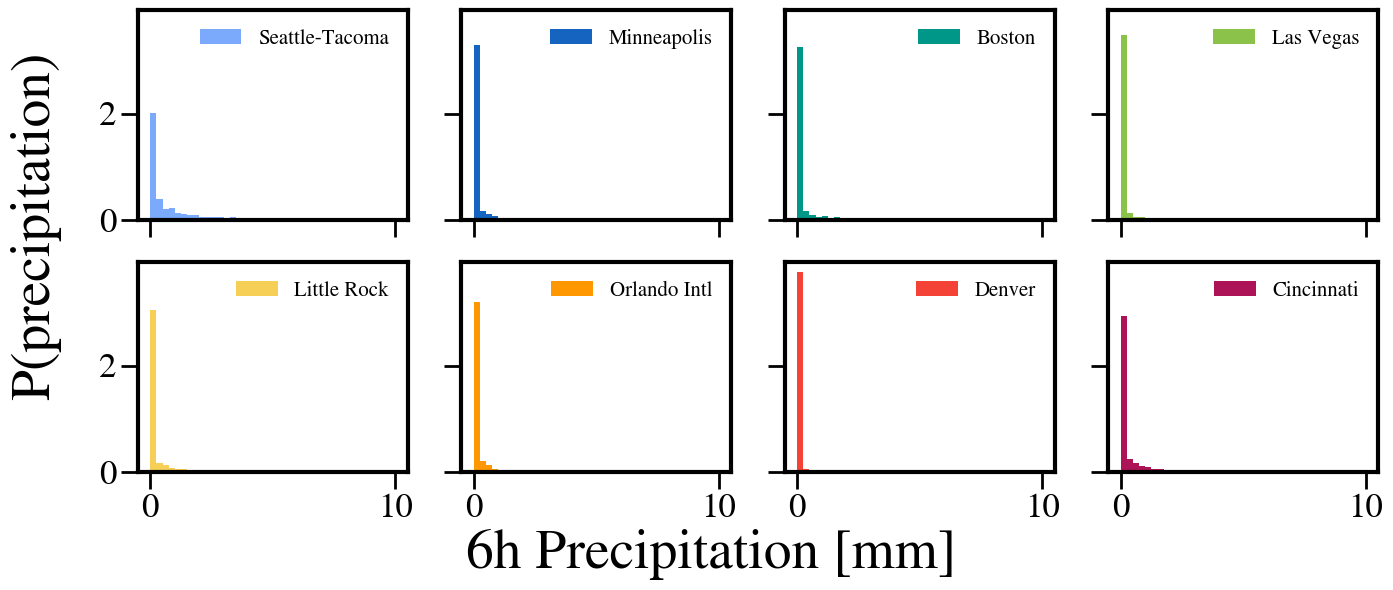

In [13]:
fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hrange=(0,10)
print('Plotting nonzero GEFS precip values')
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(clip_precip[:,:,stat]), color=colors[stat], bins=40,range=hrange, density=True,label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.25, s='P(precipitation)', rotation='vertical',fontdict={'fontsize': 40})

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

Plotting nonzero GEFS precip values


Text(0.045, 0.04, 'Non-exceedance Probability')

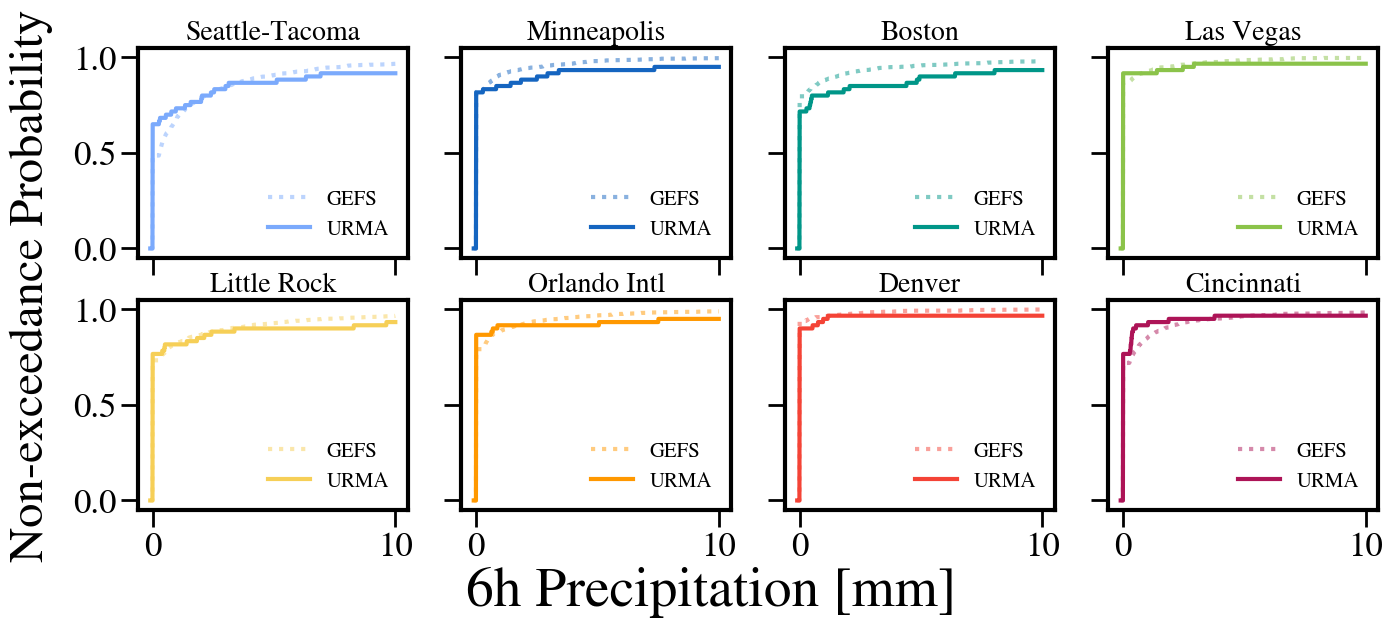

In [15]:
x = np.linspace(-0.1,10, 1000)

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hrange=(.254,10)
print('Plotting nonzero GEFS precip values')
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        gcdf = ECDF(np.ravel(clip_precip[:,:,stat]))
        ucdf = ECDF(np.ravel(clip_urma[:,stat]))
        axes[i,j].plot(x, gcdf(x), color=colors[stat], lw=3,ls=":",alpha=0.5, label='GEFS')
        axes[i,j].plot(x, ucdf(x), color=colors[stat], lw=3, label='URMA')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.04, s='Non-exceedance Probability', rotation='vertical',fontdict={'fontsize': 35})

In [23]:
from histogram import histogram, percentile_from_histogram, value_from_histogram

Now all of Adam's stuff is in xarray, so need to stick the precipitation data into a data array.

In [222]:
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names),
                          name='APCP')

In [223]:
bins = np.arange(0,20,0.1)

gefs_hist = histogram(gefs_precip, bins)

Text(0.5, 1.0, 'plt hist')

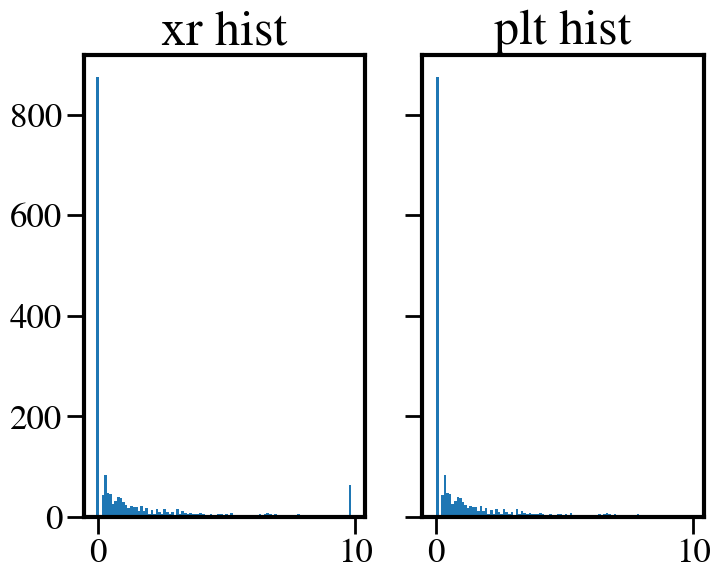

In [32]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
stat=0
axes[0].bar(bins[:-1], width=0.1,height=np.sum(gefs_hist.data[:,stat,:], axis=0))
axes[1].hist(np.ravel(clip_precip[:,:,stat]), bins=bins)

axes[0].set_title('xr hist')
axes[1].set_title('plt hist')

In [12]:
urma_precip = xr.DataArray(data=clip_urma, dims=['day','station'], 
                           coords=dict(day=np.arange(60), station=st_names),
                          name='APCP')

In [13]:
urma_hist = histogram(urma_precip, bins)

Text(0.5, 1.0, 'plt hist')

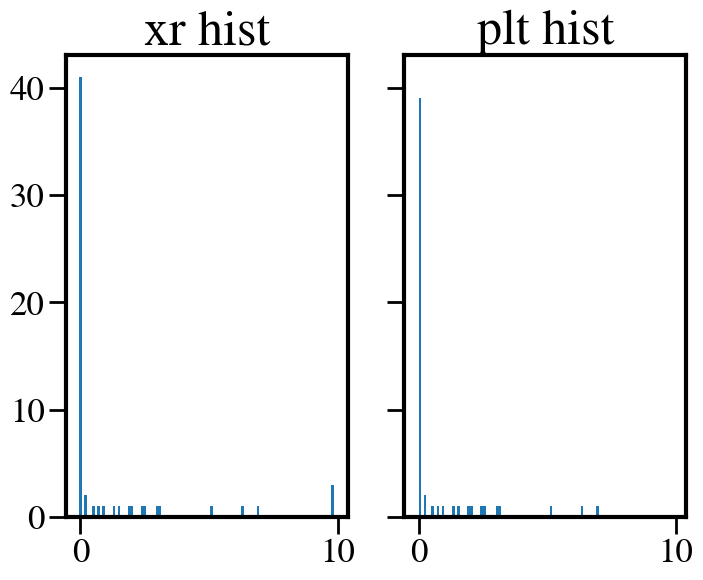

In [36]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
stat=0
axes[0].bar(bins[:-1], width=0.1,height=urma_hist.data[stat,:])
axes[1].hist(np.ravel(clip_urma[:,stat]), bins=bins)

axes[0].set_title('xr hist')
axes[1].set_title('plt hist')

Next step: calculate corrections to each GEFS quantile based on the values from the URMA histograms

In [29]:
gefs_hist.sum(dim='member')

<xarray.DataArray 'histogram_APCP' (station: 9, APCP_bin: 99)>
array([[ 875,    0,   43,   84,   48,   46,   25,   32,   40,   38,   29,
          24,   18,   22,   19,   19,   11,   21,   12,   18,    6,   13,
           6,   15,   10,    6,   15,   10,    6,    9,    3,   16,    5,
          11,    7,    6,    7,    5,    6,    5,    7,    5,    4,    4,
           6,    1,    1,    6,    5,    2,    5,    2,    8,    2,    1,
           4,    2,    4,    3,    2,    2,    2,    1,    5,    0,    5,
           7,    5,    2,    5,    2,    2,    0,    1,    1,    2,    2,
           1,    5,    3,    4,    2,    2,    0,    1,    1,    0,    1,
           0,    1,    0,    0,    2,    1,    0,    1,    1,    2,   63],
       [1474,    0,   22,   29,   29,   18,   23,   13,   16,   12,    5,
           9,    8,    9,    2,    7,    4,    5,    4,    3,    5,    3,
           4,    0,    1,    5,    2,    8,    2,    1,    1,    4,    0,
           4,    0,    2,    1,    2,    3,    2,    4,    5,    3,    0,
           2,    4,    2,    2,    1,    0,    1,    3,    0,    2,    0,
           1,    1,    0,    0,    2,    0,    1,    0,    0,    2,    0,
           0,    1,    1,    0,    2,    0,    1,    0,    1,    1,    2,
           0,    0,    0,    0,    0,    0,    1,    0,    0,    1,    0,
           1,    0,    0,    0,    0,    1,    0,    0,    1,    0,    8],
       [1433,    0,   34,   25,   18,   16,   16,   21,    9,    5,   12,
          11,    9,    2,    7,    7,   12,    6,    6,    2,    8,    2,
...
           0,    1,    0,    0,    0,    0,    1,    0,    0,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    2],
       [1673,    0,   12,   15,   16,    5,    4,    3,    3,    4,    1,
           2,    4,    0,    4,    1,    1,    3,    0,    1,    1,    1,
           3,    1,    3,    2,    2,    4,    0,    1,    1,    1,    1,
           5,    0,    2,    0,    1,    0,    0,    1,    0,    0,    0,
           0,    1,    0,    1,    0,    0,    0,    1,    2,    0,    1,
           1,    1,    0,    1,    0,    0,    0,    2,    0,    1,    0,
           0,    2,    0,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2],
       [1295,    0,   28,   49,   32,   37,   30,   24,   16,   19,   22,
          16,   11,   10,   11,    5,   12,   11,    3,   10,    8,    7,
           8,    8,    3,    4,    7,    3,    4,    3,    1,    4,    3,
           1,    2,    3,    1,    2,    1,    0,    2,    2,    0,    3,
           3,    2,    3,    2,    3,    1,    3,    2,    1,    1,    0,
           1,    2,    1,    1,    0,    1,    0,    3,    5,    1,    0,
           0,    0,    1,    1,    0,    0,    1,    0,    0,    0,    0,
           1,    0,    1,    1,    0,    0,    2,    0,    0,    0,    1,
           0,    0,    0,    0,    1,    1,    0,    0,    1,    0,   31]])
Coordinates:
  * station   (station) object 'SEATTLE-TACOMA' 'MINNEAPOLIS' ... 'Cincinnati'
  * APCP_bin  (APCP_bin) float64 0.05 0.15 0.25 0.35 ... 9.55 9.65 9.75 9.85

In [224]:
p = percentile_from_histogram(gefs_hist.sum(dim='member'), gefs_precip)

In [31]:
p

<xarray.DataArray 'percentile_APCP' (station: 9, day: 60, member: 30)>
array([[[83.05555556, 90.66666667, 83.05555556, ..., 66.27777778,
         48.61111111, 51.        ],
        [51.        , 58.33333333, 48.61111111, ..., 48.61111111,
         91.5       , 72.33333333],
        [48.61111111, 48.61111111, 83.05555556, ..., 48.61111111,
         48.61111111, 60.88888889],
        ...,
        [76.27777778, 55.66666667, 74.61111111, ..., 60.88888889,
         78.11111111, 83.61111111],
        [48.61111111, 48.61111111, 48.61111111, ..., 48.61111111,
         48.61111111, 58.33333333],
        [48.61111111, 48.61111111, 48.61111111, ..., 48.61111111,
         48.61111111, 48.61111111]],

       [[81.88888889, 81.88888889, 81.88888889, ..., 81.88888889,
         81.88888889, 91.16666667],
        [87.33333333, 81.88888889, 86.33333333, ..., 81.88888889,
         81.88888889, 81.88888889],
        [99.55555556, 89.33333333, 90.88888889, ..., 93.83333333,
         89.33333333, 93.33333333],
...
        [92.94444444, 92.94444444, 92.94444444, ..., 92.94444444,
         92.94444444, 92.94444444],
        [92.94444444, 92.94444444, 92.94444444, ..., 92.94444444,
         92.94444444, 92.94444444],
        [92.94444444, 92.94444444, 92.94444444, ..., 92.94444444,
         92.94444444, 92.94444444]],

       [[71.94444444, 71.94444444, 71.94444444, ..., 71.94444444,
         71.94444444, 92.        ],
        [71.94444444, 71.94444444, 76.22222222, ..., 71.94444444,
         71.94444444, 71.94444444],
        [90.44444444, 93.27777778, 91.61111111, ..., 92.44444444,
         98.27777778, 93.66666667],
        ...,
        [71.94444444, 71.94444444, 71.94444444, ..., 71.94444444,
         71.94444444, 71.94444444],
        [71.94444444, 71.94444444, 71.94444444, ..., 71.94444444,
         71.94444444, 71.94444444],
        [71.94444444, 71.94444444, 71.94444444, ..., 71.94444444,
         71.94444444, 71.94444444]]])
Coordinates:
  * station  (station) object 'SEATTLE-TACOMA' 'MINNEAPOLIS' ... 'Cincinnati'
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29

In [225]:
v = value_from_histogram(urma_hist, p)

In [33]:
v

<xarray.DataArray 'APCP_bin' (station: 9, day: 60, member: 30)>
array([[[2.05, 5.15, 2.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 5.15, 0.55],
        [0.05, 0.05, 2.05, ..., 0.05, 0.05, 0.05],
        ...,
        [0.95, 0.05, 0.75, ..., 0.05, 1.35, 2.45],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]],

       [[0.05, 0.05, 0.05, ..., 0.05, 0.05, 1.85],
        [0.85, 0.05, 0.25, ..., 0.05, 0.05, 0.05],
        [9.85, 1.45, 1.85, ..., 2.95, 1.45, 2.55],
        ...,
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]],

       [[0.45, 0.55, 0.45, ..., 0.45, 0.45, 0.45],
        [2.05, 0.45, 0.45, ..., 0.45, 2.05, 0.45],
        [0.45, 0.45, 0.45, ..., 0.45, 0.45, 0.45],
        ...,
...
        ...,
        [0.55, 0.55, 0.55, ..., 0.55, 0.55, 0.55],
        [0.55, 0.55, 0.55, ..., 0.55, 0.55, 0.55],
        [0.55, 0.55, 0.55, ..., 0.55, 0.55, 0.55]],

       [[2.65, 0.05, 2.75, ..., 0.05, 0.25, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        ...,
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]],

       [[0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.45],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.35, 0.45, 0.35, ..., 0.45, 1.85, 0.55],
        ...,
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]]])
Coordinates:
    APCP_bin  (station, day, member) float64 2.05 5.15 2.05 ... 0.05 0.05 0.05
  * station   (station) object 'SEATTLE-TACOMA' 'MINNEAPOLIS' ... 'Cincinnati'
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29

In [34]:
gefs_precip

<xarray.DataArray 'APCP' (day: 60, member: 30, station: 9)>
array([[[ 2.6651895 ,  0.        ,  0.        , ...,  2.5519731 ,
          2.23717046,  0.        ],
        [ 4.97550201,  0.        ,  0.38431358, ...,  0.        ,
          0.        ,  0.        ],
        [ 2.61683416,  0.        ,  0.        , ...,  7.8623929 ,
          6.79361391,  0.        ],
        ...,
        [ 0.87738949,  0.        ,  0.        , ...,  0.3251977 ,
          0.37026617,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.34905463,
          0.44878903,  0.        ],
        [ 0.29797074,  1.05026853,  0.        , ...,  0.        ,
          0.        ,  2.11347437]],

       [[ 0.29735398,  0.50228268,  0.81681931, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.42445689,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.43142092,  0.        , ...,  0.        ,
          0.        ,  0.37966168],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48991081,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
  * station  (station) object 'SEATTLE-TACOMA' 'MINNEAPOLIS' ... 'Cincinnati'

Plotting nonzero GEFS precip values


Text(0.045, 0.25, 'P(precipitation)')

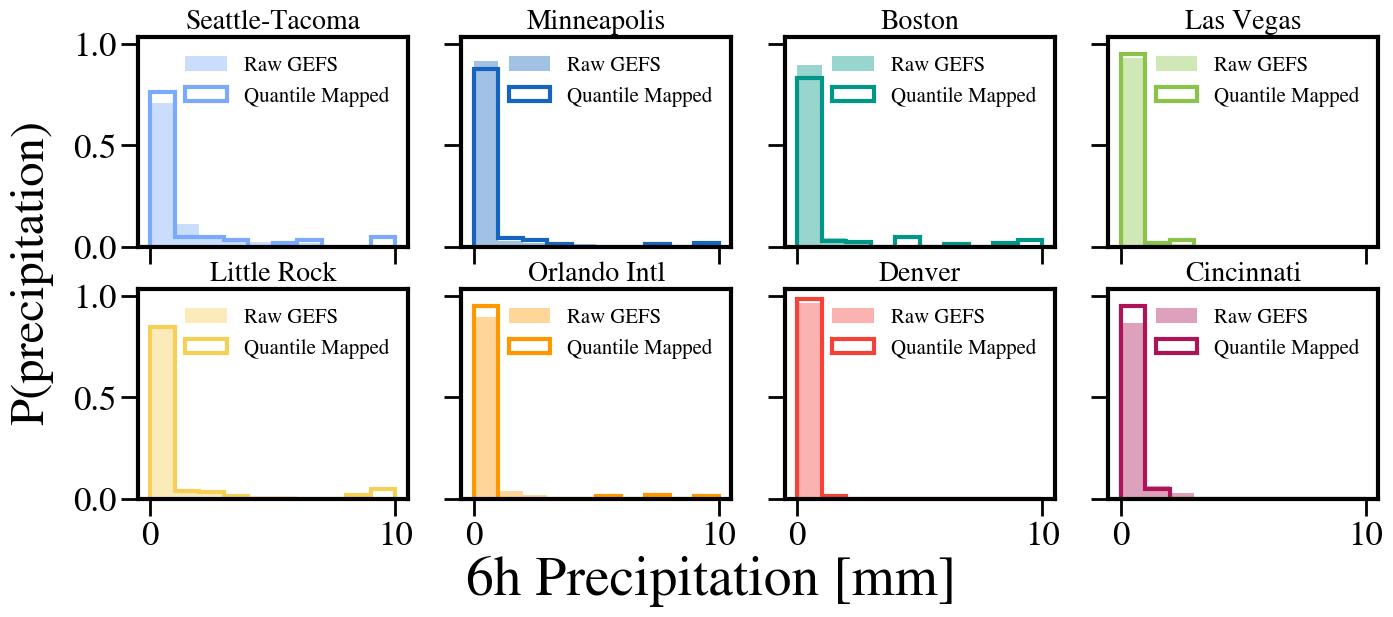

In [44]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(0,10)
print('Plotting nonzero GEFS precip values')
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(gefs_precip[:,:,stat]), range=(0,10), density=True, alpha=0.4, color=colors[stat],label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, :,:]), range=(0,10), histtype='step', lw=3,color=colors[stat],density=True, label='Quantile Mapped')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.25, s='P(precipitation)', rotation='vertical',fontdict={'fontsize': 35})

# Bias

In [21]:
### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/20230119/urma2p5.2023011900.pcp_06h.wexp.grb2',
                   engine='grib2io')

In [22]:
a_to_conus = a.grib2io.interp('bilinear', conus_grid)

In [23]:
a_at_stations = a_to_conus.APCP.data[conus_gp[0], conus_gp[1]]

{230.0: ([<matplotlib.lines.Line2D at 0x14a35380e9e0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14a35380ec50>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14a35380ef20>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14a35380f1c0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14a35380f460>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14a35380f700>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14a35380f9a0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14a35380fc40>], [])}

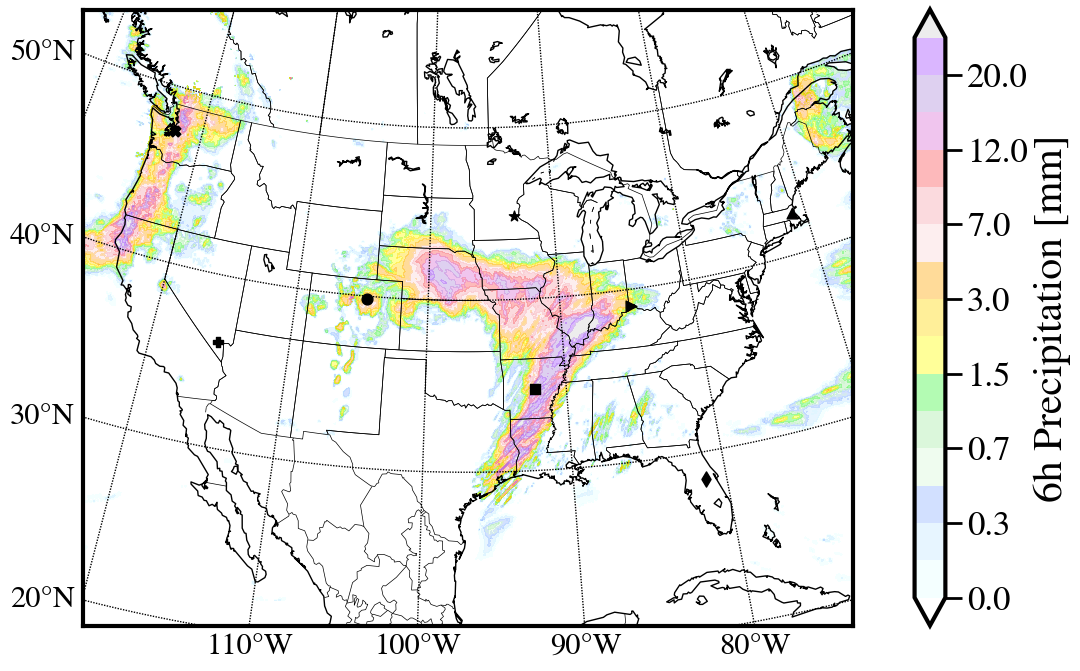

In [89]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

lats, lons = a_to_conus.latitude.data, a_to_conus.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,a_to_conus.APCP.data,extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.4,colors=colorst)
cbar=plt.colorbar(cs)
cbar.set_label(f'6h Precipitation [mm]')

#supp locations
markers=['X', '*', '^', 'P', 's', 'd', 'o', 'o', '>']
for loc in range(len(station_lats)):
    if loc == 7:
        continue
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=60, marker=markers[loc], color='black')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [94]:
g = xr.open_mfdataset('/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/20230115/gefs??.t0z.f96',
                   engine='grib2io', combine='nested', concat_dim='perturbationNumber')

In [95]:
glats, glons = g.latitude.data, g.longitude.data

{230.0: ([<matplotlib.lines.Line2D at 0x14a35010caf0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14a35010cd60>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14a35010d000>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14a35010d2a0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14a35010d540>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14a35010d7e0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14a35010da80>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14a35010dd20>], [])}

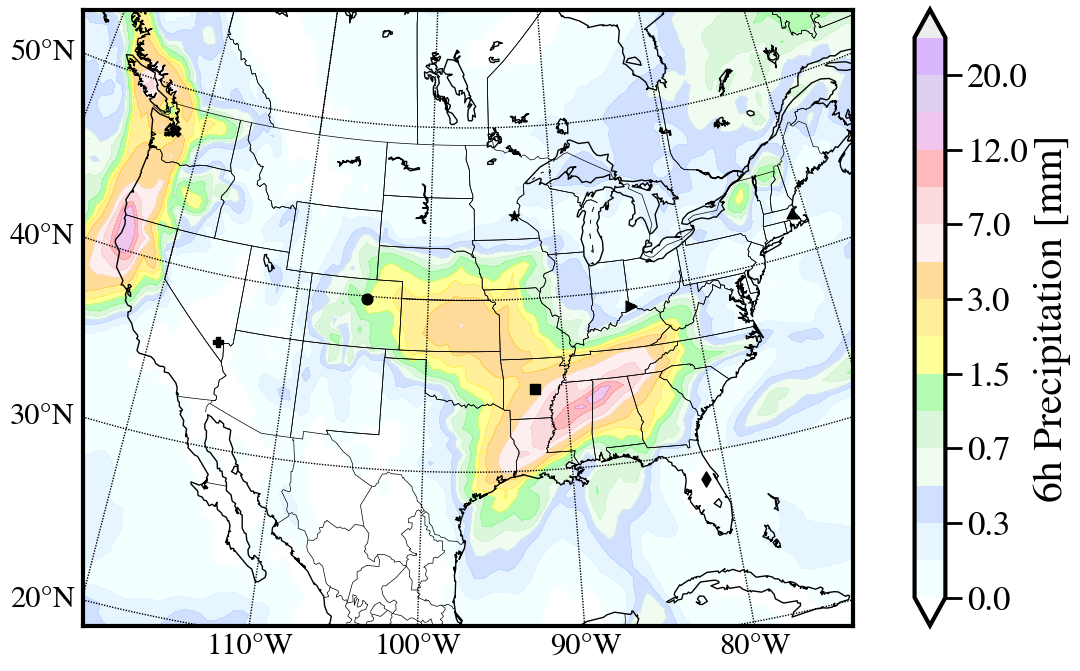

In [96]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

lats, lons = glats, glons
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,g.APCP.mean(dim='perturbationNumber'),extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.4,colors=colorst)
cbar=plt.colorbar(cs)
cbar.set_label(f'6h Precipitation [mm]')

#supp locations
markers=['X', '*', '^', 'P', 's', 'd', 'o', 'o', '>']
for loc in range(len(station_lats)):
    if loc == 7:
        continue
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=60, marker=markers[loc], color='black')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [51]:
a_at_stations

array([ 1.6249619,  0.       ,  0.       ,  0.       , 18.689455 ,
        0.       ,  4.7339406,  2.5938797,  2.094429 ], dtype=float32)

Plotting nonzero GEFS precip values


Text(0.051, 0.5, 'P')

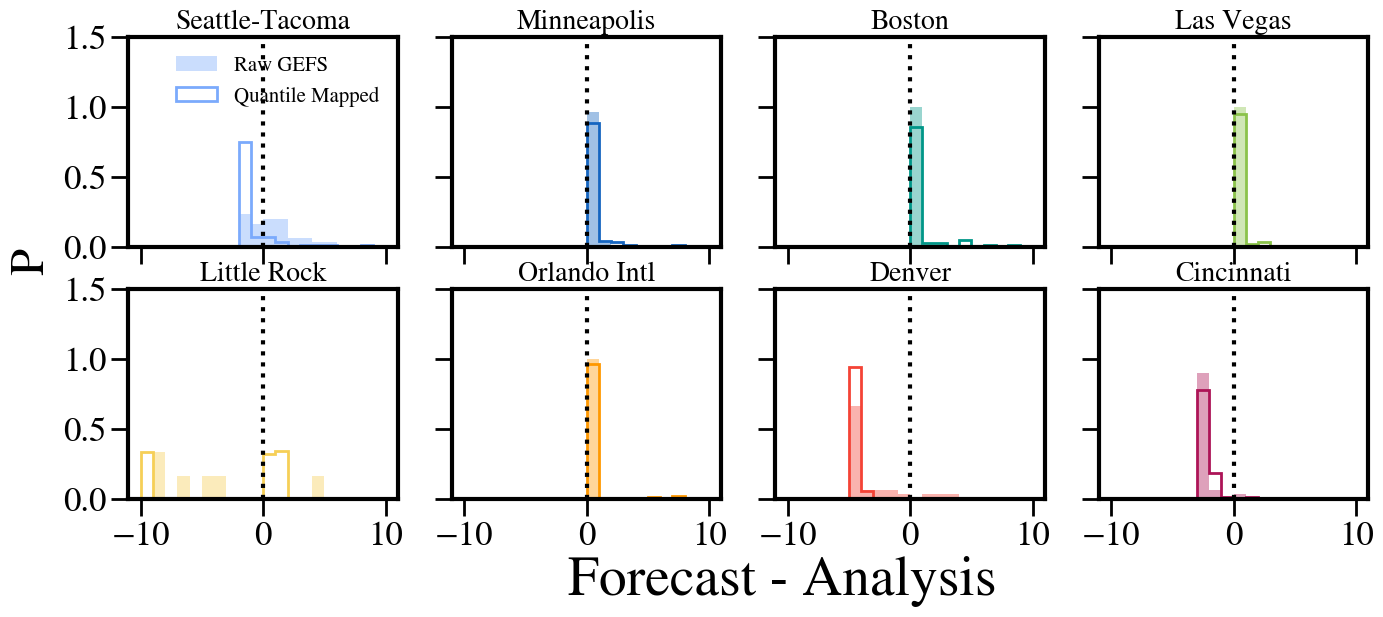

In [234]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-10,10)
axes[0,0].set_ylim([0,1.5])
print('Plotting nonzero GEFS precip values')
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(gefs_precip[0,:,stat])-a_at_stations[stat], range=hrange, bins=20, density=True, alpha=0.4, color=colors[stat],label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=20,histtype='step', lw=2,color=colors[stat],density=True,label='Quantile Mapped')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=3, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15)

fig.text(x=0.4, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

# Now add supplemental locations

This will be added in the quantile mapping part...so each ensemble member will get 50 more members. 

Let's back up. Each station will have itself + 50 other points. Each point will make a histogram summed over its members with data from all 60 days. 

In [16]:
from histogram import histogram, percentile_from_histogram, value_from_histogram

In [8]:
## First, supplemental location data

sl = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/test_default_params///blend.supplemental_locations_1.co.2p5.nc')

In [13]:
sl

<xarray.Dataset> Size: 4GB
Dimensions:        (ya: 1597, xa: 2345, xsupp: 50)
Coordinates:
    latitude       (ya, xa) float32 15MB ...
    longitude      (ya, xa) float32 15MB ...
Dimensions without coordinates: ya, xa, xsupp
Data variables:
    xlocations     (xsupp, ya, xa) float64 1GB ...
    ylocations     (xsupp, ya, xa) float64 1GB ...
    nsupplemental  (ya, xa) float32 15MB ...
    differences    (xsupp, ya, xa) float32 749MB ...
Attributes:
    domain:   co
    month:    1

In [9]:
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

In [10]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),50)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2023,1,15)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]


        

  0%|          | 0/60 [00:00<?, ?it/s]

In [11]:
## URMA ##
urma_files = sorted(glob('/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/*/urma2p5.*.pcp_06h.wexp.grb2'))

sl_urma_at_stations = np.zeros((60,len(st_names),50)) #days, stations, each station's SLs

bad_count = 0
start_day = datetime.date(2023,1,15)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    try:
        ds = xr.open_dataset(file, engine='grib2io')
    except:
        bad_count += 1
        sl_urma_at_stations[day, :,:] = np.full((len(st_names),50),np.nan)
        continue
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]

  0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, sl_precip_at_stations*0, sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254,sl_urma_at_stations*0, sl_urma_at_stations)

In [13]:
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(50)),
                          name='APCP')

In [14]:
urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(50)),
                          name='APCP')

In [17]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [47]:
np.shape(gefs_precip)

(60, 30, 9, 50)

In [18]:
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [19]:
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

In [57]:
# gefs dims = day member station location
# v dims = station day member location

Text(0.045, 0.25, 'P(precipitation)')

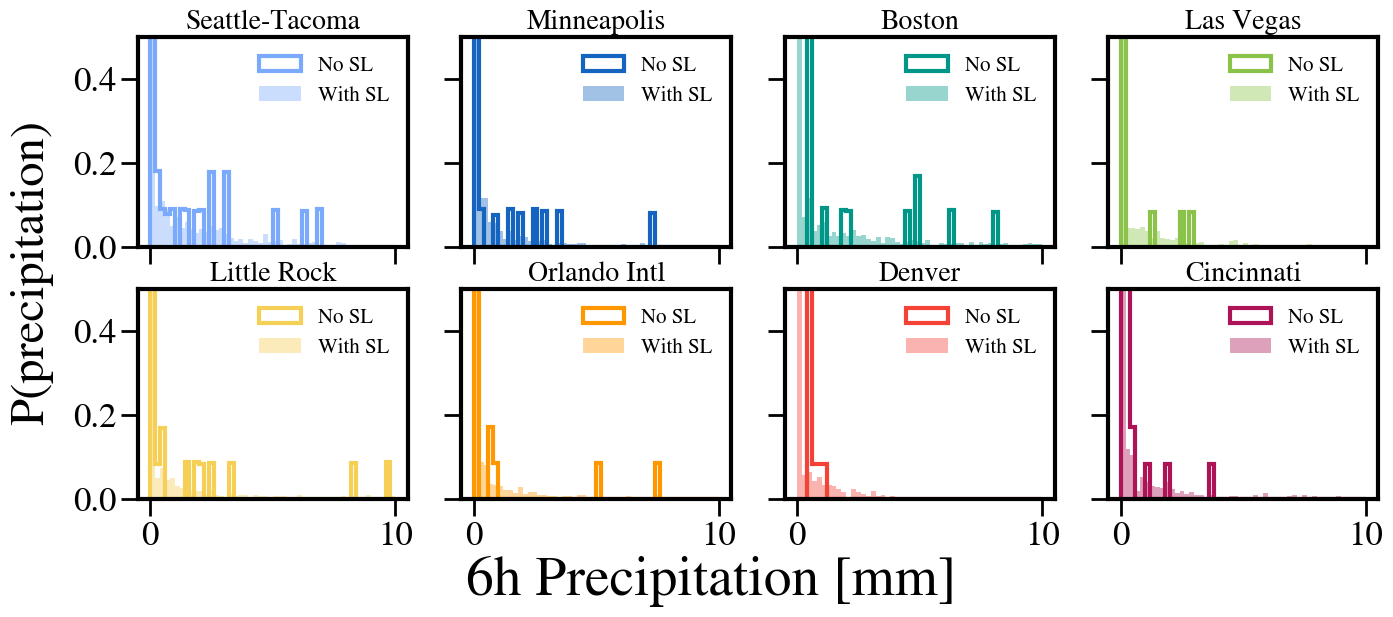

In [78]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(0,10)
axes[0,0].set_ylim([0,0.5])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        #axes[i,j].hist(np.ravel(gefs_precip[:,:,stat,0]), range=(0,10),bins=50, density=True, alpha=0.4, color=colors[stat],label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, :,:]), range=(0,10), histtype='step',bins=40, lw=3,color=colors[stat],density=True, label='No SL')
        axes[i,j].plot([])
        axes[i,j].hist(np.ravel(v_with_sl[stat, :,:,:]), range=(0,10), bins=40, alpha=0.4,color=colors[stat],density=True, label='With SL')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.25, s='P(precipitation)', rotation='vertical',fontdict={'fontsize': 35})

Plotting nonzero GEFS precip values


Text(0.051, 0.5, 'P')

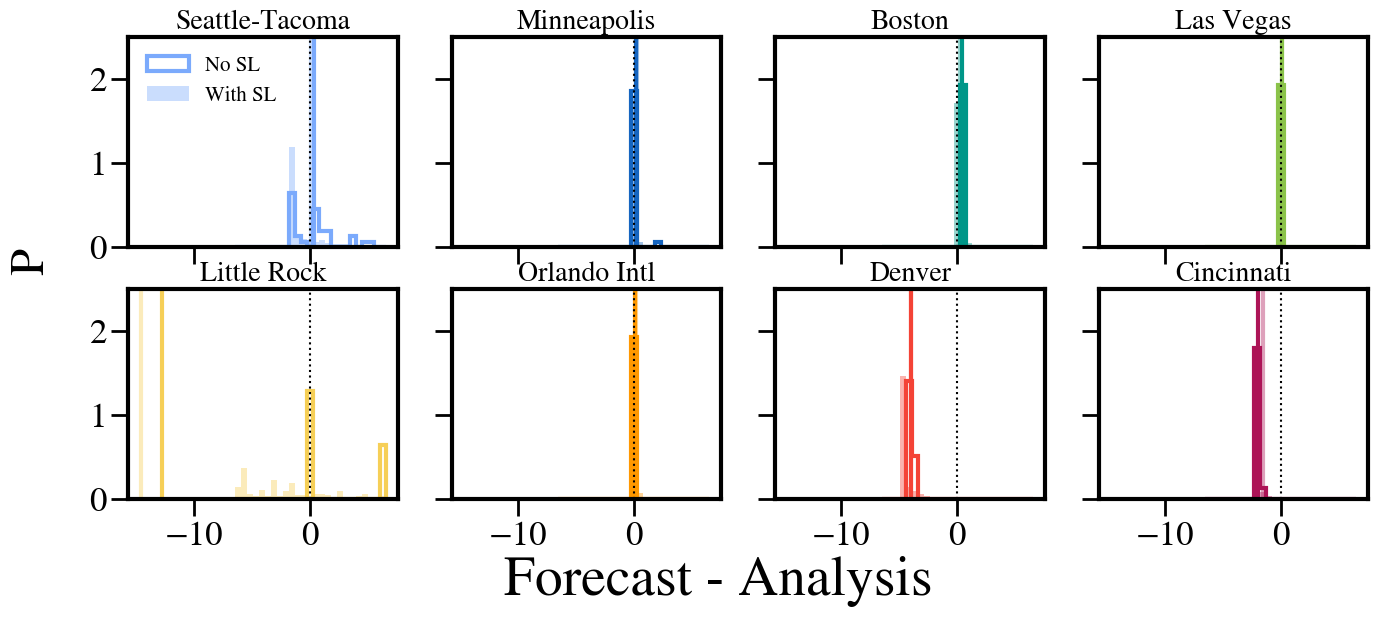

In [26]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-6.5,6.5)
axes[0,0].set_ylim([0,2.5])
print('Plotting nonzero GEFS precip values')
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        #axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.4, color=colors[stat],label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        #mn = np.mean(np.ravel(v[stat, 0,:])-a_at_stations[stat])
        #axes[i,j].plot([mn, mn], [0,5], color=colors[stat], lw=3)
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        #mn = np.mean(np.ravel(v_with_sl[stat, 0,:])-a_at_stations[stat])
        #axes[i,j].plot([mn, mn], [0,5], color=colors[stat], lw=3, alpha=0.4)
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

## July 22

In [23]:
## First, supplemental location data
month = 7

sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4//blend.supplemental_locations_{month}.co.2p5.nc')

In [24]:
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

In [30]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),50)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2024,month,22)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]
        ds.close()


        

  0%|          | 0/60 [00:00<?, ?it/s]

In [31]:
## URMA ##
sl_urma_at_stations = np.zeros((60,len(st_names),50)) #days, stations, each station's SLs

bad_count = 0
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    try:
        ds = xr.open_dataset(file, engine='grib2io')
    except:
        bad_count += 1
        sl_urma_at_stations[day, :,:] = np.full((len(st_names),50),np.nan)
        continue
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]
    ds.close()

  0%|          | 0/60 [00:00<?, ?it/s]

In [33]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, 0., sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254,0., sl_urma_at_stations)

In [34]:
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(50)),
                          name='APCP')

In [35]:
urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(50)),
                          name='APCP')

In [36]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [37]:
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [38]:
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

In [40]:
station_points

,call,link1,name,state,elev,lat,lon,tz,comment
0,KSEA,SEA,SEATTLE-TACOMA,WA,450,47.4500,-122.3000,-8,COMMISSIONED 10/01/96 NWRFC ...
1,KMSP,MSP,MINNEAPOLIS,MN,838,44.8833,-93.2167,-6,COMMISSIONED 06/01/96 MBRFC ...
2,KBOS,BOS,BOSTON,MA,29,42.3667,-71.0333,-5,COMMISSIONED ASOS 4/1/96 ...
3,KLAS,LAS,LAS VEGAS ASOS,NV,2180,36.0833,-115.1667,-8,COMMISSIONED 9/1/95 CNRFC/CBRFC RPT TIME-...
4,KLIT,LIT,LITTLE ROCK,AR,257,34.7333,-92.2333,-6,...
5,KMCO,MCO,ORLANDO INTL,FL,105,28.4333,-81.3167,-5,COMMISSIONED 07/01/96 ...
6,KDEN,DEN,DENVER INTL ASOS,CO,5431,39.8466,-104.6562,-7,DVX 2/94 CHNGD TO DEN 2/28/95 1ST SAO 8Z NMC ...
7,KDEN,DEN,DENVER STAPLETON,CO,5332,39.7500,-104.8667,-7,CALL LETTERS REUSED LAST SAO 2/28/95 AT 07Z ...
8,KCVG,CVG,COVINGTON ASOS,KY,877,39.0500,-84.6667,-5,COMMISSIONED 10/1/95 ...


Text(0.045, 0.25, 'P(precipitation)')

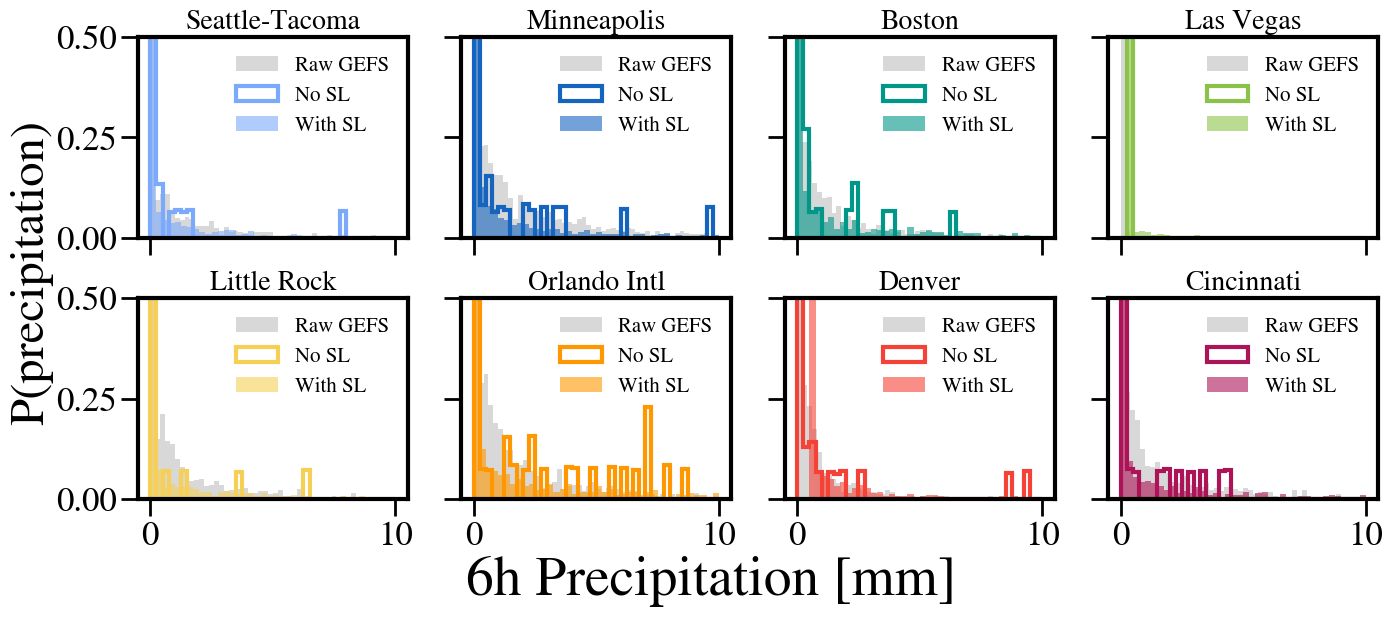

In [43]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']


fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3)
hrange=(0,10)
axes[0,0].set_ylim([0,0.5])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat=8
        axes[i,j].hist(np.ravel(gefs_precip[:,:,stat,0]), range=(0,10),bins=50, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, :,:]), range=(0,10), histtype='step',bins=40, lw=3,color=colors[stat],density=True, label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, :,:,:]), range=(0,10), bins=40, alpha=0.6,color=colors[stat],density=True, label='With SL')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.25, s='P(precipitation)', rotation='vertical',fontdict={'fontsize': 35})

In [44]:
#### Bias

def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t
    
#when is GEFS data valid
mem = 4
temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96',
                      engine='grib2io')

dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
temp.close()

### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/urma2p5.{dt}00.pcp_06h.wexp.grb2',
                   engine='grib2io')


In [48]:
dt

'20240726'

In [45]:
a_to_conus = a.grib2io.interp('bilinear', conus_grid)
a_at_stations = a_to_conus.APCP.data[conus_gp[0], conus_gp[1]]

Text(0.051, 0.5, 'P')

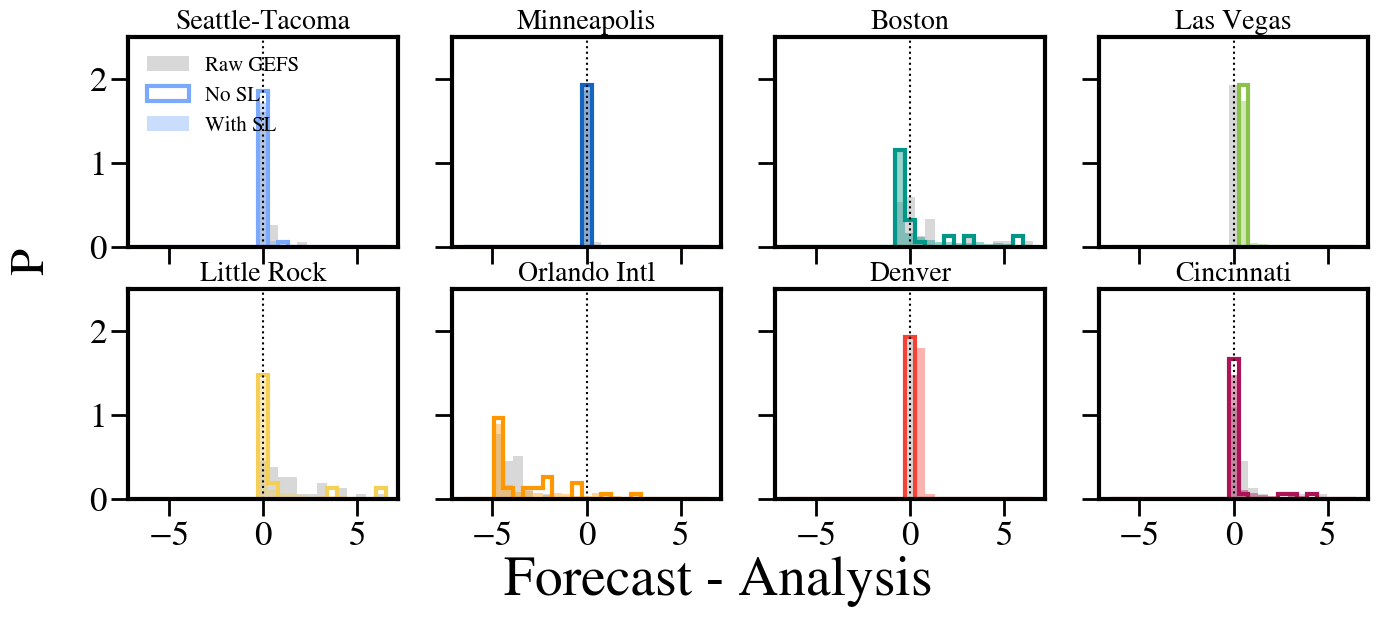

In [47]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-6.5,6.5)
axes[0,0].set_ylim([0,2.5])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

# Alaska

In [2]:
## First, supplemental location data
month = 7

sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_{month}.ak.3p0.nc')

In [3]:
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

In [4]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['PANC','PAFA','PAJN', 'PABE','PARC','PAFM'])

def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

ak_gp = (lat_idx, lon_idx)

In [5]:
station_points

,call,link1,name,state,elev,lat,lon,tz,comment
0,PANC,,ANCHORAGE,AK,132,61.1697,-150.0261,-9,10/2001-AS OF 5/7/01 OFFICIAL NAME TED STEVEN...
1,PAFA,FAI,FAIRBANKS,AK,454,64.8167,-147.8667,-9,...
2,PAJN,AJK,JUNEAU,AK,24,58.3667,-134.5833,-9,...
3,PABE,BET,BETHEL,AK,150,60.7833,-161.8000,-9,...
4,PARC,,ARCTIC_VILLAGE,AK,2087,68.1200,-145.5700,-9,...
5,PAFM,,AMBLER,AK,289,67.1000,-157.8500,-9,PREVIOUSLY INCORRECTLY IDENTIFIED AS FIVE MIL...


In [6]:
#rename weird ones
st_names = station_points['name'].copy()
st_names[4] = 'Arctic Village'

In [7]:
from histogram import histogram, percentile_from_histogram, value_from_histogram

In [8]:
#first, get CONUS grid info
from nimbl.metadata import get_metadata
import grib2io

ak_grid_def = get_metadata('grib2_section3', model='blend',region='ak' )
ak_grid = grib2io.Grib2GridDef(ak_grid_def[4], ak_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


In [9]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),50)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2024,month,22)
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_ak = ds.grib2io.interp('bilinear', ak_grid)
        precip = ds_to_ak.APCP.data
        for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]


        

  0%|          | 0/60 [00:00<?, ?it/s]

In [10]:
#when is GEFS data valid
mem = 4
temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96',
                      engine='grib2io')

In [11]:
## URMA ##
sl_urma_at_stations = np.zeros((60,len(st_names),50)) #days, stations, each station's SLs

bad_count = 0
for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    #pcpurma_ak.2024060500.06h.grb2
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/pcpurma_ak.{this_day.strftime("%Y%m%d")}00.06h.grb2'
    try:
        ds = xr.open_dataset(file, engine='grib2io')
    except:
        bad_count += 1
        print(this_day)
        sl_urma_at_stations[day, :,:] = np.full((len(st_names),50),np.nan)
        continue
    ds_to_ak = ds.grib2io.interp('bilinear', ak_grid)
    precip = ds_to_ak.APCP.data
    for stat in range(len(st_names)):
            #get supplemental locations
            for sl in range(50):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]

  0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, 0., sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254, 0., sl_urma_at_stations)

In [13]:
#set up histograms
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(50)),
                          name='APCP')

urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(50)),
                          name='APCP')

In [14]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [15]:
#without SLs
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [16]:
#with SLs
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

Text(0.045, 0.25, 'P(precipitation)')

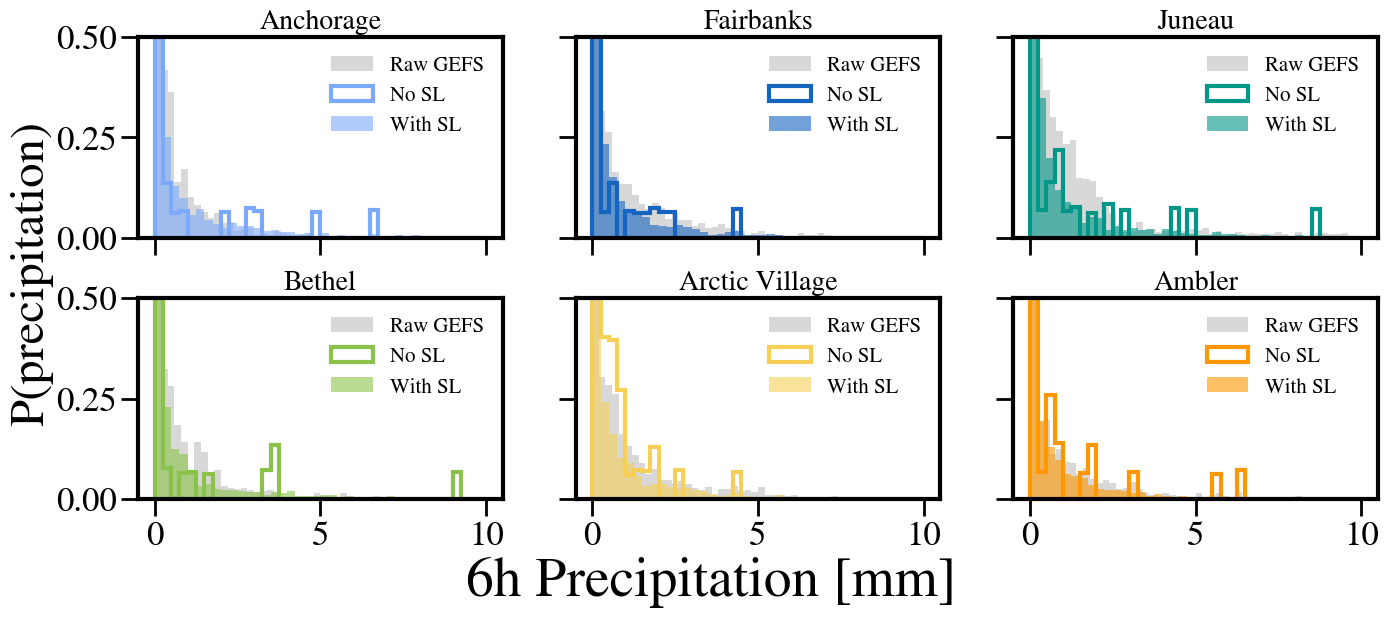

In [80]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 
'#ad1457ff']

fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3)
hrange=(0,10)
axes[0,0].set_ylim([0,0.5])
for i in range(2):
    for j in range(3):
        stat = 3*i+j
        axes[i,j].hist(np.ravel(gefs_precip[:,:,stat,0]), range=(0,10),bins=50, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, :,:]), range=(0,10), histtype='step',bins=40, lw=3,color=colors[stat],density=True, label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, :,:,:]), range=(0,10), bins=40, alpha=0.6,color=colors[stat],density=True, label='With SL')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=15)

fig.text(x=0.33, y=-0.05, s='6h Precipitation [mm]', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.25, s='P(precipitation)', rotation='vertical',fontdict={'fontsize': 35})

In [17]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

In [18]:
dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
temp.close()

In [19]:
### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/pcpurma_ak.{dt}00.06h.grb2',
                   engine='grib2io')

In [20]:
a_to_ak = a.grib2io.interp('bilinear', ak_grid)
a_at_stations = a_to_ak.APCP.data[ak_gp[0], ak_gp[1]]

Text(0.051, 0.5, 'P')

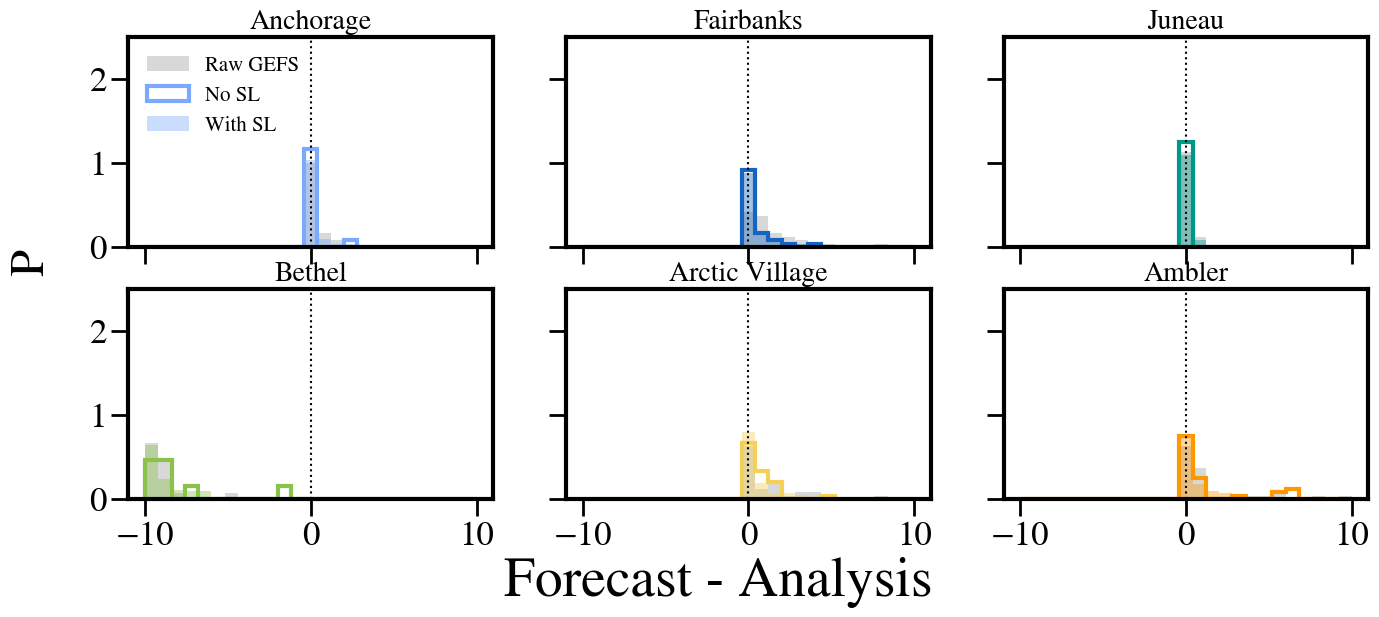

In [22]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-10,10)
axes[0,0].set_ylim([0,2.5])
for i in range(2):
    for j in range(3):
        stat = 3*i+j
        axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})

# Now some tests

Specifically, I wonder if the performance of the supplemental locations can be improved by cherry picking the best locations (instead of just using all 50). In Hamill+2017 (the NBM paper) they use only the SLs with a penalty value below some number (in their case, it was $\Delta$ = 0.3 but that obviously depends on the choice of penalty weights, etc.), which is an easy test.

We could also use the Pearson correlations similarly, though this would  of course select the "best" locations based on climotology alone, which could be risky given that the penalty function weighs differences in terrain higher than differences in climotology. 

Other tests will neccesitate changing the actual SL algorithm: one idea is to just simply weight the climotology higher than the terrain. The other is to keep the overall weights the same but change the internal weighting of the percentiles used to quantify the difference in climotologies. In essence, the precipitation CDF penalty function can be reworked to put heavier weight on top percentiles of precipitation, with the reasoning of it’s more important to match extreme/significant precip events than it is to match small amounts

## use SLs below some threshold

In [52]:
## First, supplemental location data
month = 7
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4//blend.supplemental_locations_{month}.co.2p5.nc')
#unpack lats and lons to index over
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

differences = sl.differences.data

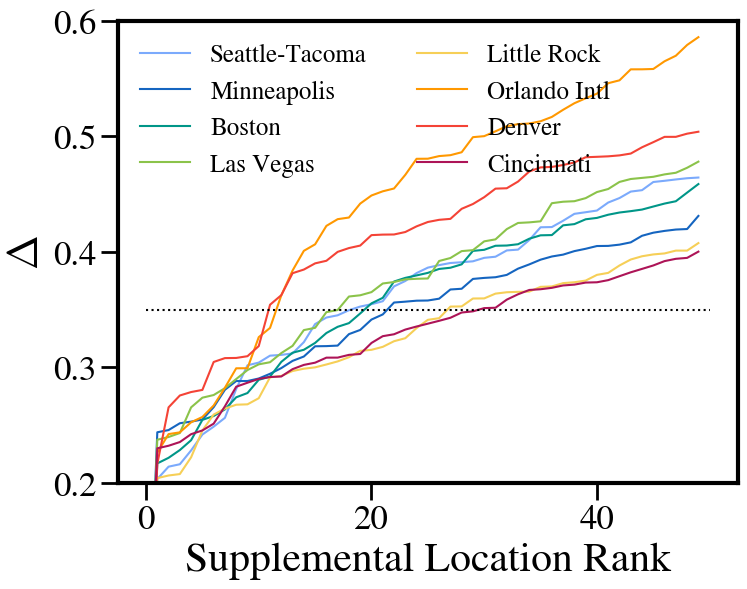

In [55]:
diffs_at_locs = differences[:,conus_gp[0], conus_gp[1]]
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(len(st_names)):
    if i == 7:
        #skip duplicated Denver station
        continue
    plt.plot(np.arange(50), diffs_at_locs[:,i], color=colors[i],label=st_names[i].title())

plt.plot([0,50],[0.35,0.35], ls=':', color='black')

plt.ylabel(f'$\Delta$')
plt.xlabel('Supplemental Location Rank')

plt.ylim([0.2,0.6])
plt.legend(frameon=False, fontsize=18,ncol=2)

In [58]:
diffs_at_locs[:,5]

array([0.        , 0.22622824, 0.24229345, 0.24380791, 0.25252336,
       0.25712252, 0.2670604 , 0.28246468, 0.29926577, 0.29930788,
       0.32624966, 0.33422345, 0.3624183 , 0.38393596, 0.40096337,
       0.4066177 , 0.42256686, 0.42838103, 0.42980185, 0.44186038,
       0.44888496, 0.45249873, 0.4549359 , 0.46676862, 0.48064107,
       0.4807266 , 0.4829939 , 0.48377892, 0.48632956, 0.49938065,
       0.50025797, 0.5044508 , 0.50885165, 0.5106647 , 0.51120603,
       0.51315135, 0.51690054, 0.5230806 , 0.52876157, 0.5330664 ,
       0.5370351 , 0.54610467, 0.548589  , 0.55809516, 0.55812865,
       0.5584111 , 0.5650984 , 0.56988686, 0.5792042 , 0.5859626 ],
      dtype=float32)

In [64]:
#penalty threshold, only SLs with differences < threshold are used
threshold = 0.35

for stat in range(len(st_names)):
    sl_above_threshold = np.where(diffs_at_locs[:,stat] <= threshold)[0]
    print(f"{st_names[stat].title()} has {len(sl_above_threshold)} SLs below threshold")

print("-------------------------------")

Seattle-Tacoma has 19 SLs below threshold
Minneapolis has 22 SLs below threshold
Boston has 20 SLs below threshold
Las Vegas has 18 SLs below threshold
Little Rock has 27 SLs below threshold
Orlando Intl has 12 SLs below threshold
Denver has 11 SLs below threshold
Denver Stapleton has 10 SLs below threshold
Cincinnati has 30 SLs below threshold
-------------------------------


One complication: if we have different numbers of SLs for each location, I can't stack them together like above. 

Do I make a ragged list of lists?

Update: This way isn't viable...in order to make the histograms for the quantile mapping, we have to turn the nested arrays into DataArrays, which can only work if all dimenions are the same legnth -- this won't be true if we select by threshold. Perhaps we take the average # of SLs below the threshold?

In [74]:
#penalty threshold, only SLs with differences < threshold are used
threshold = 0.35
num_sls = []

print(f"THRESHOLD = {threshold}")
for stat in range(len(st_names)):
    sl_above_threshold = np.where(diffs_at_locs[:,stat] <= threshold)[0]
    num_sls.append(len(sl_above_threshold))
    print(f"{st_names[stat].title()} has {num_sls[-1]} SLs below threshold")

print("-------------------------------")
print(f'Average # of SLs below threshold = {int(np.mean(num_sls))}')
ave_under_thresh = int(np.mean(num_sls))

THRESHOLD = 0.35
Seattle-Tacoma has 19 SLs below threshold
Minneapolis has 22 SLs below threshold
Boston has 20 SLs below threshold
Las Vegas has 18 SLs below threshold
Little Rock has 27 SLs below threshold
Orlando Intl has 12 SLs below threshold
Denver has 11 SLs below threshold
Denver Stapleton has 10 SLs below threshold
Cincinnati has 30 SLs below threshold
-------------------------------
Average # of SLs below threshold = 18


This way, we take the first 18 SLs (can do this since the SLs are saved in rank order w.r.t. difference)

In [75]:
## GEFS
sl_precip_at_stations = np.zeros((60, 30, len(st_names),ave_under_thresh)) #days, ensemble mems, stations, each station's SLs

start_day = datetime.date(2024,month,22)


for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    for mem in range(1,31):
        file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96'
        ds = xr.open_dataset(file, engine='grib2io')
        ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
        precip = ds_to_co.APCP.data
        for stat in range(len(st_names)):
            for sl in range(ave_under_thresh):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_precip_at_stations[day, mem-1, stat,sl] = precip[y_thisloc, x_thisloc]


        

  0%|          | 0/60 [00:00<?, ?it/s]

In [77]:
## URMA ##
sl_urma_at_stations = np.zeros((60,len(st_names),ave_under_thresh)) #days, stations, each station's SLs

for day in tqdm(range(60)):
    this_day = start_day - datetime.timedelta(days=day)
    #pcpurma_ak.2024060500.06h.grb2
    file = f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{this_day.strftime("%Y%m%d")}/urma2p5.{this_day.strftime("%Y%m%d")}00.pcp_06h.wexp.grb2'
    ds = xr.open_dataset(file, engine='grib2io')
    ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
    precip = ds_to_co.APCP.data
    for stat in range(len(st_names)):
            for sl in range(ave_under_thresh):
                x_thisloc = xlocs[sl,lat_idx[stat], lon_idx[stat]]
                y_thisloc = ylocs[sl,lat_idx[stat], lon_idx[stat]]
                #bookkeeping for fortran --> python indices
                x_thisloc = int(x_thisloc)-1
                y_thisloc = int(y_thisloc)-1  
                sl_urma_at_stations[day, stat,sl] = precip[y_thisloc, x_thisloc]

  0%|          | 0/60 [00:00<?, ?it/s]

In [79]:
#set precip < 0.254 mm == 0 precip
clip_precip = np.where(sl_precip_at_stations<0.254, 0., sl_precip_at_stations)
clip_urma = np.where(sl_urma_at_stations<0.254, 0., sl_urma_at_stations)

In [80]:
#set up histograms
gefs_precip = xr.DataArray(data=clip_precip, dims=['day', 'member', 'station', 'location'], 
                           coords=dict(day=np.arange(60), member=np.arange(30), station=st_names, location=np.arange(ave_under_thresh)),
                          name='APCP')

urma_precip = xr.DataArray(data=clip_urma, dims=['day','station', 'location'], 
                           coords=dict(day=np.arange(60), station=st_names, location=np.arange(ave_under_thresh)),
                          name='APCP')

In [81]:
bins = np.logspace(np.log10(0.254), 1.7, 500)#np.arange(0,20,0.1)
bins = np.insert(bins, 0, 0.)
urma_hist = histogram(urma_precip, bins)
gefs_hist = histogram(gefs_precip, bins)

In [82]:
#without SLs
p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip[:,:,:,0])
v = value_from_histogram(urma_hist.sel(location=0), p)

In [83]:
#with SLs
p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip)
v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)

In [84]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

In [85]:
#when is GEFS data valid
mem = 4
temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs{mem:02d}.t0z.f96',
                      engine='grib2io')
dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
temp.close()

In [86]:
### URMA analysis for date corresponding to GEFS valid time ###
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/urma2p5.{dt}00.pcp_06h.wexp.grb2',
                   engine='grib2io')

In [87]:
a_to_co = a.grib2io.interp('bilinear', conus_grid)
a_at_stations = a_to_co.APCP.data[conus_gp[0], conus_gp[1]]

Text(0.051, 0.5, 'P')

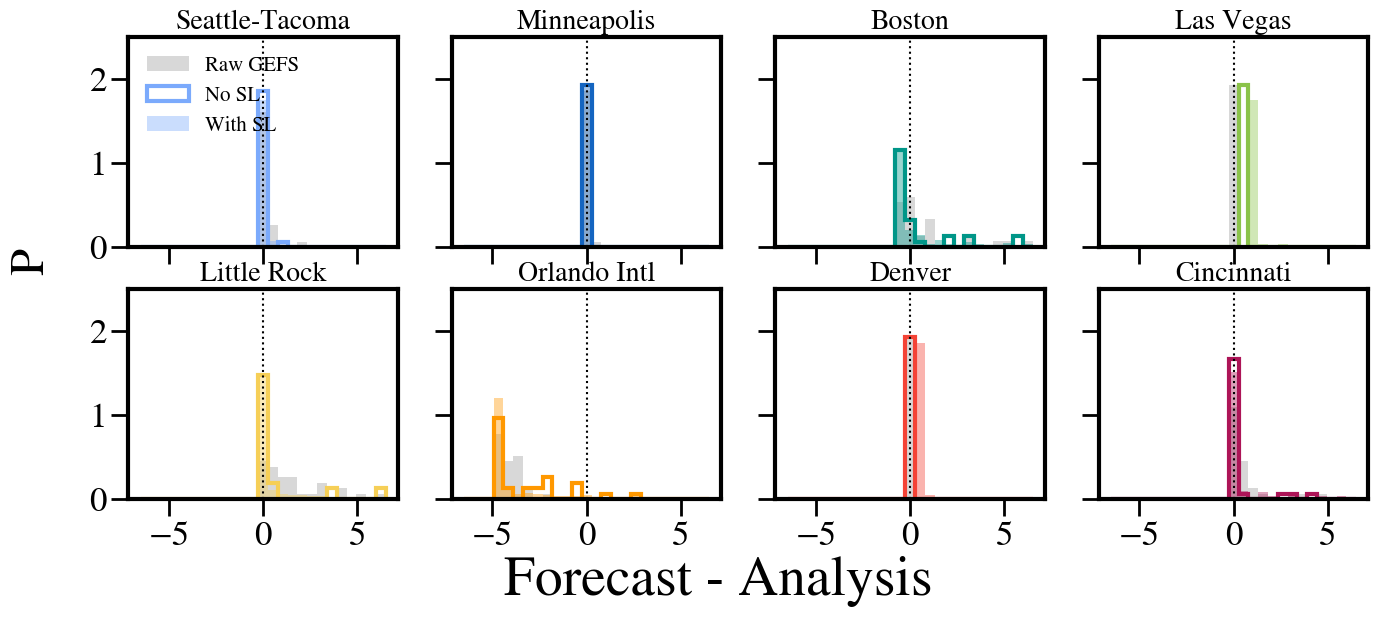

In [88]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16, 6))
hrange=(-6.5,6.5)
axes[0,0].set_ylim([0,2.5])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].hist(np.ravel(gefs_precip[0,:,stat,0])-a_at_stations[stat], range=hrange, bins=25, density=True, alpha=0.3, color='gray',label='Raw GEFS')
        axes[i,j].hist(np.ravel(v[stat, 0,:])-a_at_stations[stat], range=hrange, bins=25,histtype='step', lw=3,color=colors[stat],density=True,label='No SL')
        axes[i,j].hist(np.ravel(v_with_sl[stat, 0,:,:])-a_at_stations[stat], range=hrange, bins=25,alpha=0.4,color=colors[stat],density=True,label='With SL')
        axes[i,j].plot([0,0], [0,3], ls=':', lw=1.5, color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
axes[0,0].legend(frameon=False, fontsize=15, loc='upper left')

fig.text(x=0.36, y=-0.05, s='Forecast - Analysis', fontdict={'fontsize': 40})
fig.text(x=0.051, y=0.5, s='P', rotation='vertical',fontdict={'fontsize': 35})